# Chapter 4
# Finite-Dimensional Optimization

In this chapter we examine methods for optimizing a function with respect to a finite
number of variables. In the finite-dimensional optimization problem, one is given a
real-valued function $f$ defined on $X \subset R^n$ and asked to find an $x^* \in X$ such that
$f(x^*) \geq f(x)$ for all $x \in X$. We denote this problem

$$\max_{x \in X} f(x)$$

and call $f$ the objective function, $X$ the feasible set, and $x^*$, if it exists, a maximum.

There is a close relationship between the finite-dimensional optimization problems
discussed in this chapter and the rootfinding and complementarity problems
discussed in the previous chapter. The first-order necessary conditions of an unconstrained
problem pose a rootfinding problem; the Karush-Kuhn-Tucker first-order
necessary conditions of a constrained optimization problem pose a complementarity
problem. The rootfinding and complementarity problems associated with optimization
problems are special in that they possess a natural merit function, the objective
function itself, which may be used to determine whether iterations are converging on
a solution.

Over the years, numerical analysts have studied finite-dimensional optimization
problems extensively and have devised a variety of algorithms for solving them quickly
and accurately. We begin our discussion with derivative-free methods, which are useful
if the objective function is rough or if its derivatives are expensive to compute.
We then turn to Newton-type methods for unconstrained optimization, which employ
derivatives or derivative estimates to locate an optimum. Univariate unconstrained
optimization methods are of particular interest because many multivariate optimization
algorithms use the strategy of first determining a linear direction to move in,
and then finding the optimal point in that direction. We conclude with a discussion
of how to solve constrained optimization problems.

## 4.1 Derivative-Free Methods

As was the case with univariate rootfinding, optimization algorithms exist that will
place progressively smaller brackets around a local maximum of a univariate function.
Such methods are relatively slow, but do not require the evaluation of function
derivatives and are guaranteed to find a local optimum to a prescribed tolerance in a
known number of steps.

The most widely-used derivative-free method is the **golden search** method.

Suppose
we wish to find a local maximum of a continuous univariate function $f(x)$ on
the interval $[a, b]$. 

Pick any two numbers in the interior of the interval, say $x_1$ and $x_2$
with $x_1 < x_2$. 

Evaluate the function and replace the original interval with $[a, x_2]$ if
$f(x_1) > f(x_2)$ or with $[x_1, b]$ if $f(x_2) \geq f(x_1)$.

A key issue is how to pick the interior evaluation points. 

Two simple criteria lead
to the most widely-used strategy. 

First, the length of the new interval should be
independent of whether the upper or lower bound is replaced.

Second, on successive
iterations, one should be able to reuse an interior point from the previous iteration so
that only one new function evaluation is performed per iteration.


These conditions
are uniquely satisfied by selecting $x_i = a + \alpha_i (b - a)$, where

$$\alpha_1 = \frac{3-\sqrt 5}{2}$$

$$\alpha_2 = \frac{\sqrt 5 -1}{2}$$

The value $\alpha_2$ is known as the golden ratio, a number dear to the hearts of Greek
philosophers and Renaissance artists.

In [2]:
import numpy as np
from numpy import append, array, diagonal, tril, triu
from numpy.linalg import inv
from scipy.linalg import lu
#from scipy.linalg import solve
from pprint import pprint
from numpy import array, zeros, diag, diagflat, dot
np.random.seed(123)
import warnings

from sympy import *
import sympy as sym
init_printing()

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

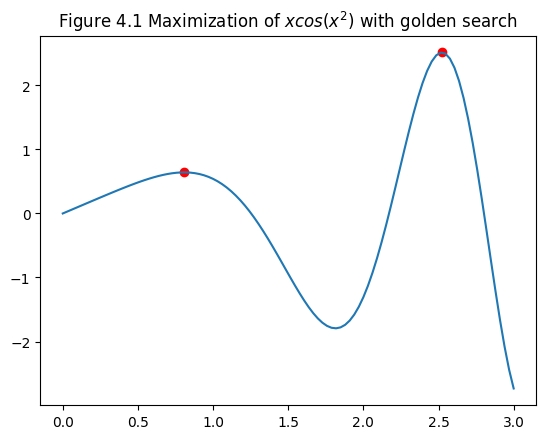

In [11]:
x0= np.array([0,3])
f = lambda x: x * np.cos(x ** 2)
a,b = 0,3

x = np.linspace(0,3, 100)
y = f(x)
plt.figure()
plt.plot(x,y)
plt.scatter( np.array([0.8083,2.5234]), f(np.array([0.8083,2.5234])) , c='r' )
plt.title("Figure 4.1 Maximization of $x cos(x^2)$ with golden search");

In [12]:
f = lambda x: x * np.cos(x ** 2)
a,b = 0,3

def mygolden(f, a, b, maxit = 1000, tol = 1/10000):
    #Define the ratios
    alpha1 = (3 - np.sqrt(5)) / 2
    alpha2 = (np.sqrt(5) - 1) / 2
    #Prevent mistakes in the initial set
    if a > b:
        a, b = b, a

    #Compute the first two interior points        
    x1 = a + alpha1 * (b - a)
    x2 = a + alpha2 * (b - a)

    #Compute the associated values of f(.)
    f1, f2 = f(x1), f(x2)

    #Initialize the update factor (in the first iteration it is different)
    d = (alpha1 * alpha2)*(b - a)
    #Iterate until convergence
    while d > tol:
        #Compute the update factor
        d = d * alpha2 # alpha2 is the golden ratio
        #Generate a new interior point
        if f2 < f1: # x2 is new upper bound
            x2, x1 = x1, x1 - d
            f2, f1 = f1, f(x1)
        else:  # x1 is new lower bound
            x1, x2 = x2, x2 + d
            f1, f2 = f2, f(x2)
            
    if f1>f2:
        x = x2
    else:
        x = x1      
    return x    

In [13]:
mygolden(f, 0, 3)

In [14]:
mygolden(f, 2, 3)

Execution of this script yields the result $x^* = 0.8083$. As can be seen in Figure 4.1,
this point is a local maximum, but not a global maximum in $[0, 3]$. The golden search
method is guaranteed to find the global maximum when the function is concave.
However, as the present example makes clear, this need not be true when the optimand
is not concave.

Now, let's consider two simple cases where the function's maximum is at a boundary. Up to a small numerical error, the golden search method selects the correct maximum over the admissable set.

In [11]:
f_2 = lambda x: 1.0-x

In [12]:
mygolden(f_2, 0, 1)

In [13]:
f_3 = lambda x: 2*x

In [14]:
mygolden(f_3, 0, 1)

Now, let's consider a case where the function's maximum is to the left of the first guess. Also in this case, up to a small numerical error, the golden search method selects the correct maximum over the admissable set.

In [15]:
f_4 = lambda x: 1.0-x**2.0

In [16]:
mygolden(f_4, -0.1, 1)

## Nelder-Mead algorithm

Another widely-used derivative-free optimization method for multivariate functions
is the **Nelder-Mead algorithm**.

The Nelder-Mead algorithm is simple, but slow and unreliable. However, if a
problem involves only a single optimization or costly function and derivative evaluations,
the Nelder-Mead algorithm is worth trying. In many problems an optimization
problem that is embedded in a larger problem must be solved repeatedly, with the
function parameters perturbed slightly with each iteration. For such problems, which
are common is dynamic models, one generally will want to use a method that moves
more quickly and reliably to the optimum, given a good starting point.


(source: https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method)


The Nelder–Mead method or downhill simplex method or amoeba method is a commonly applied numerical method used to find the minimum or maximum of an objective function in a multidimensional space. It is applied to nonlinear optimization problems for which derivatives may not be known. However, the Nelder–Mead technique is a heuristic search method that can converge to non-stationary points[1] on problems that can be solved by alternative methods.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Nelder-Mead_Rosenbrock.gif/640px-Nelder-Mead_Rosenbrock.gif)

(source: http://www.scholarpedia.org/article/Nelder-Mead_algorithm)

The Nelder-Mead algorithm or simplex search algorithm, originally published in 1965 (Nelder and Mead, 1965), is one of the best known algorithms for multidimensional unconstrained optimization without derivatives. This method should not be confused with Dantzig's simplex method for linear programming, which is completely different, as it solves a linearly constrained linear problem.

The basic algorithm is quite simple to understand and very easy to use. For these reasons, it is very popular in many fields of science and technology, especially in chemistry and medicine.

The method does not require any derivative information, which makes it suitable for problems with non-smooth functions. It is widely used to solve parameter estimation and similar statistical problems, where the function values are uncertain or subject to noise. It can also be used for problems with discontinuous functions, which occur frequently in statistics and experimental mathematics.

In [17]:
#https://github.com/fchollet/nelder-mead/blob/master/nelder_mead.py

'''
    Pure Python/Numpy implementation of the Nelder-Mead algorithm.
    Reference: https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method
'''
import copy

def nelder_mead(f, x_start,
                step=0.1, no_improve_thr=10e-6,
                no_improv_break=10, max_iter=0,
                alpha=1., gamma=2., rho=-0.5, sigma=0.5):
    '''
    @param f (function): function to optimize, must return a scalar score
        and operate over a numpy array of the same dimensions as x_start
    @param x_start (numpy array): initial position
    @param step (float): look-around radius in initial step
    @no_improv_thr,  no_improv_break (float, int): break after no_improv_break iterations with
        an improvement lower than no_improv_thr
    @max_iter (int): always break after this number of iterations.
        Set it to 0 to loop indefinitely.
    @alpha, gamma, rho, sigma (floats): parameters of the algorithm
        (see Wikipedia page for reference)
    return: tuple (best parameter array, best score)
    '''
    # init
    dim = len(x_start)
    prev_best = f(x_start)
    no_improv = 0
    res = [[x_start, prev_best]]

    for i in range(dim):
        x = copy.copy(x_start)
        x[i] = x[i] + step
        score = f(x)
        res.append([x, score])

    # simplex iter
    iters = 0
    while 1:
        # order
        res.sort(key=lambda x: x[1])
        best = res[0][1]

        # break after max_iter
        if max_iter and iters >= max_iter:
            return res[0]
        iters += 1

        # print intermediate results
        print('...Best so far:', best)

        # break after no_improv_break iterations with no improvement        
        if best < prev_best - no_improve_thr:
            no_improv = 0
            prev_best = best
        else:
            no_improv += 1

        if no_improv >= no_improv_break:
            return res[0]

        # centroid
        x0 = [0.] * dim
        for tup in res[:-1]:
            for i, c in enumerate(tup[0]):
                x0[i] += c / (len(res)-1)

        # reflection
        xr = x0 + alpha*(x0 - res[-1][0])
        rscore = f(xr)
        if res[0][1] <= rscore < res[-2][1]:
            del res[-1]
            res.append([xr, rscore])
            continue

        # expansion
        if rscore < res[0][1]:
            xe = x0 + gamma*(x0 - res[-1][0])
            escore = f(xe)
            if escore < rscore:
                del res[-1]
                res.append([xe, escore])
                continue
            else:
                del res[-1]
                res.append([xr, rscore])
                continue

        # contraction
        xc = x0 + rho*(x0 - res[-1][0])
        cscore = f(xc)
        if cscore < res[-1][1]:
            del res[-1]
            res.append([xc, cscore])
            continue

        # reduction (shrinkage)
        x1 = res[0][0]
        nres = []
        for tup in res:
            redx = x1 + sigma*(tup[0] - x1)
            score = f(redx)
            nres.append([redx, score])
        res = nres



In [18]:
import math
import numpy as np

#f(x,y) = x^2 - 4*x + y^2 - y - x*y;
# f = lambda x: x[0]**2- 4*x[0] + x[1]**2- x[1] - x[0]*x[1]

def f(x):
    return x[0]**2- 4*x[0] + x[1]**2- x[1] - x[0]*x[1]

Note: Nelder-Mead routines are typically written to find a minimum

In [19]:
nelder_mead(f, np.array([0., 0.]))

...Best so far: -0.39
...Best so far: -0.7275000000000001
...Best so far: -1.393125
...Best so far: -2.3526562500000003
...Best so far: -3.5309765625000002
...Best so far: -5.2233691406250005
...Best so far: -5.2233691406250005
...Best so far: -5.4678515625
...Best so far: -6.543889160156251
...Best so far: -6.543889160156251
...Best so far: -6.789999999999999
...Best so far: -6.789999999999999
...Best so far: -6.826440582275392
...Best so far: -6.897784576416015
...Best so far: -6.9442303848266596
...Best so far: -6.981286070346831
...Best so far: -6.981286070346831
...Best so far: -6.996554707437753
...Best so far: -6.996554707437753
...Best so far: -6.996554707437753
...Best so far: -6.998806264159649
...Best so far: -6.99950646219463
...Best so far: -6.99950646219463
...Best so far: -6.999729285131592
...Best so far: -6.999917718013711
...Best so far: -6.999956529064557
...Best so far: -6.999956529064557
...Best so far: -6.999987054451326
...Best so far: -6.999992395468407
...Best 

[array([2.99996614, 2.00000911]), -6.99999999846253]

For our example, trying to compute a maximum would lead to a nonsensical result (the function diverges because it is unbounded)

In [20]:
def g(x):
    return -f(x)

In [21]:
nelder_mead(g, np.array([0., 0.]))

...Best so far: -0.0
...Best so far: -0.7425
...Best so far: -1.2731250000000005
...Best so far: -3.5657812499999997
...Best so far: -6.120820312500001
...Best so far: -15.370986328125001
...Best so far: -29.952473144531254
...Best so far: -79.11109680175784
...Best so far: -180.1401594543457
...Best so far: -501.75054828643806
...Best so far: -1279.2158525562288
...Best so far: -3643.2332759213455
...Best so far: -9860.796630604866
...Best so far: -28206.48932687358
...Best so far: -78465.7299783655
...Best so far: -224197.03828232182
...Best so far: -631239.0493504315
...Best so far: -1800339.1125055852
...Best so far: -5095913.178072832
...Best so far: -14514276.343491178
...Best so far: -41180750.59679981
...Best so far: -117194711.20171927
...Best so far: -332872275.96950734
...Best so far: -946867491.3180485
...Best so far: -2690776764.6109858
...Best so far: -7652101253.368438
...Best so far: -21750662060.849766
...Best so far: -61847026586.96579
...Best so far: -175816634243.93

/tmp/ipykernel_111/1635698591.py:8: RuntimeWarning: overflow encountered in scalar power
  return x[0]**2- 4*x[0] + x[1]**2- x[1] - x[0]*x[1]


[array([-1.59129307e+154,  2.49721095e+153]), -inf]

In [ ]:
#https://codesachin.wordpress.com/2016/01/16/nelder-mead-optimization/
from IPython.display import YouTubeVideo
# Evaluates the function:
# f(x,y) = x^2 - 4*x + y^2 - y - x*y;
YouTubeVideo("HUqLxHfxWqU")

##### Scipy implementation


http://www.scipy-lectures.org/advanced/mathematical_optimization/

In scipy, scipy.optimize.fmin() implements the Nelder-Mead approach:

In [ ]:
from scipy import optimize

optimize.fmin(f, [2, 2])

In [ ]:
optimize.fmin(f, [0, 0])

However, that procedure is deprecated, and there is a newer (and improved) implementation:

https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html


In [ ]:
optimize.minimize(f, [2, 2],method='Nelder-Mead')

In [ ]:
optimize.minimize(f, [0, 0],method='Nelder-Mead')